# Estimating Selection Effects

This notebook accumulates a set of samples in detector-frame masses and distances that are *detected* and corresponding weights (probability density in mass-distance space) that can be used to estimate the selection effects of our hypothetical search.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [12]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
from bisect import bisect
import h5py
import multiprocessing
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.stats import gaussian_kde
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

First, we load and construct and interpolator to give the optimal SNR for masses and distances:

In [3]:
with h5py.File('optimal_snr.h5', 'r') as f:
    ms = array(f['ms'])
    osnrs = array(f['SNR'])
    
rbs = RectBivariateSpline(ms, ms, osnrs)

def optimal_snr(m1, m2, d):
    return rbs.ev(m1, m2)/d

Then we construct an interpolator for the distribution of angular factors:

In [4]:
with h5py.File('thetas.h5', 'r') as f:
    ts = array(f['Theta'])
    
ts = np.append([0, 1], ts)
ts = np.sort(ts)

theta_icdf = interp1d(linspace(0, 1, len(ts)), ts)

Here is the distance distribution (we use the true distribution):

In [5]:
zmax = 2.25
z = expm1(linspace(log(1), log(zmax+1), 1000))
dNdz = (1+z)**2*Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value

pz = cumtrapz(dNdz, z, initial=0)
zNorm = pz[-1]
pz = pz/zNorm

zci = interp1d(pz, z)

def draw_distance_redshift(N):
    z = zci(rand(N))
    return (z, Planck15.luminosity_distance(z).to(u.Gpc).value)

/mnt/home/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


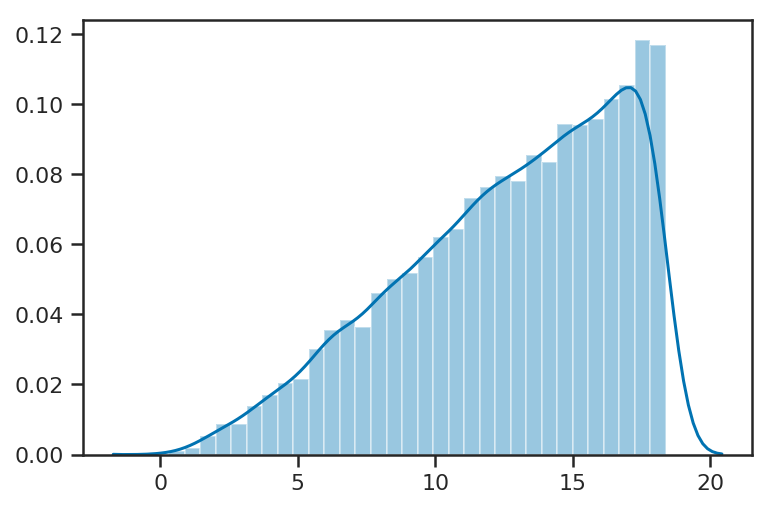

In [6]:
sns.distplot(draw_distance_redshift(10000)[1])

In [7]:
MMin = 3
MMax = 75

def draw_masses_source_frame(N):
    m1 = exp(log(MMin) + log(MMax/MMin)*rand(N))
    m2_frac = rand(N)
    m2 = MMin + (m1 - MMin)*m2_frac
    
    return (m1,m2)

Here we draw the SNRs of the masses and distances:

In [8]:
def draw_snrs(m1s, m2s, dls):
    n = len(m1s)
    
    t = theta_icdf(rand(n))
    
    return t*optimal_snr(m1s, m2s, dls) + randn(n)

In [9]:
def pm1sm2sz(m1, m2, z):
    m1norm = log(MMax/MMin)
    m2norm = m1-MMin
    
    return 1.0/m1norm/m1 * 1.0/m2norm * (1+z)**2*Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value / zNorm

def dzddl(z):
    dc = Planck15.comoving_distance(z).to(u.Gpc).value
    
    return 1.0/(dc + (1+z)*Planck15.hubble_distance.to(u.Gpc).value / Planck15.efunc(z))

And here we draw the detected events:

In [13]:
pool = multiprocessing.Pool()

Process ForkPoolWorker-16:
Process ForkPoolWorker-15:
Process ForkPoolWorker-12:
Process ForkPoolWorker-5:
Process ForkPoolWorker-27:
Process ForkPoolWorker-26:
Process ForkPoolWorker-21:
Process ForkPoolWorker-23:
Process ForkPoolWorker-20:
Process ForkPoolWorker-1:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-22:
Process ForkPoolWorker-7:
Process ForkPoolWorker-24:
Process ForkPoolWorker-13:
Process ForkPoolWorker-6:
Process ForkPoolWorker-25:
Process ForkPoolWorker-28:
Process ForkPoolWorker-18:
Process ForkPoolWorker-4:
Process ForkPoolWorker-14:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/home/wfarr/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run

In [16]:
m1s_det = []
m2s_det = []
dls_det = []
wts_det = []

N_gen = 0
chunk_size = 1 << 18
N_desired = 1 << 22

def dr(x):
    m1s, m2s = draw_masses_source_frame(chunk_size)
    zs, dls = draw_distance_redshift(chunk_size)

    m1d = m1s*(1+zs)
    m2d = m2s*(1+zs)

    wts = pm1sm2sz(m1s, m2s, zs)/(1+zs)**2*dzddl(zs)

    rho = draw_snrs(m1d, m2d, dls)

    s = rho > 8
    
    return m1d[s], m2d[s], dls[s], wts[s]

Nsucc = 0

with tqdm(total=N_desired) as bar:
    for m1d, m2d, dls, wts in pool.imap_unordered(dr, range(1000000)):
        N_gen += chunk_size
        
        m1s_det.append(m1d)
        m2s_det.append(m2d)
        dls_det.append(dls)
            
        wts_det.append(wts)
         
        n = len(m1d)
        Nsucc += n
            
        bar.update(n)
        
        if Nsucc > N_desired:
            break
            
m1s_det = np.concatenate(m1s_det)
m2s_det = np.concatenate(m2s_det)
dls_det = np.concatenate(dls_det)
wts_det = np.concatenate(wts_det)

4195883it [1:00:56, 936.35it/s]                             


In [17]:
pool.close()

And here we save them to HDF5:

In [18]:
with h5py.File('selected.h5', 'w') as f:
    f.attrs['N_gen'] = N_gen
    f.create_dataset('m1det', data=m1s_det, compression='gzip', shuffle=True)
    f.create_dataset('m2det', data=m2s_det, compression='gzip', shuffle=True)
    f.create_dataset('dl', data=dls_det, compression='gzip', shuffle=True)
    f.create_dataset('wt', data=wts_det, compression='gzip', shuffle=True)

Execute the below to re-load:

In [19]:
with h5py.File('selected.h5', 'r') as f:
    N_gen = f.attrs['N_gen']
    m1s_det = array(f['m1det'])
    m2s_det = array(f['m2det'])
    dls_det = array(f['dl'])
    wts_det = array(f['wt'])

A quick test, with a distribution that is close to our reference distribution---should come out to be close to 4000 events expected:

In [20]:
z = linspace(0, 3, 1000)
d = Planck15.luminosity_distance(z).to(u.Gpc).value

z_of_d = interp1d(d, z)

def dNdm1dm2ddl(m1det, m2det, dl):
    z = z_of_d(dl)
    
    m1 = m1det/(1+z)
    m2 = m2det/(1+z)
    
    low_cut = where(m2 < 5, 0, 1)
    high_cut = where(m1 > 40, 0, 1)
    
    dVdz = Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value*4*pi
    dzddl = 1/(dl/(1+z) + (1+z)*Planck15.hubble_distance.to(u.Gpc).value/sqrt((1+z)**3*0.3 + 0.7))
    
    alpha = 0.75
    beta = 0.0
    gamma = 3
    
    MMin = 5
    MMax = 40
    
    m1norm = (1-alpha)/(MMax**(1-alpha) - MMin**(1-alpha))
    m2norm = (beta+1)/(m1**(beta+1) - MMin**(beta+1))
    
    dN = m1norm*m2norm*m1**(-alpha)*m2**beta*(1+z)**(gamma-1)*dVdz*dzddl/(1+z)**2
    
    return low_cut * dN * high_cut

Here we calculate the number of events expected and also the Monte-Carlo uncertainty on that number, and compare to the intrinsic statistical uncertainty, $\sqrt{N}$.

In [21]:
xs = dNdm1dm2ddl(m1s_det, m2s_det, dls_det)/wts_det
s = np.sum(xs)
s2 = np.sum(xs*xs)

mu = 1/N_gen*s

v = 1/N_gen**2*s2 - mu*mu/N_gen

Nex = 0.5*5*100*mu

Neff = mu*mu/v

Nex, Neff

(3582.1186616629147, 901263.0631725055)

So, we see that we get one effective sample per $\sim 5$ detected injections:

In [22]:
nperneff = m1s_det.shape[0]/Neff
print('One effective sample per {:.1f} detected injections'.format(nperneff))

One effective sample per 4.7 detected injections


So, if we want to have $N_\mathrm{eff} \sim \mathcal{O}(10) N_\mathrm{obs}$ times, then we will need (rounded to a power of two):

In [23]:
def ceil_pow2(x):
    return 1 << int(ceil(log(x)/log(2)))

with h5py.File('observations.h5', 'r') as f:
    nobs_1yr, _ = f.attrs['1yr']
    nobs_small, _ = f.attrs['small']
    nobs_5yr, _ = f.attrs['5yr']
    
safety_factor = 10

print('nsel for small sample is {:d}'.format(ceil_pow2(safety_factor*nperneff*nobs_small)))
print('nsel for 1yr sample is {:d}'.format(ceil_pow2(safety_factor*nperneff*nobs_1yr)))
print('nsel for 5yr sample is {:d}'.format(ceil_pow2(safety_factor*nperneff*nobs_5yr)))

nsel for small sample is 8192
nsel for 1yr sample is 65536
nsel for 5yr sample is 262144
